# Project (Recommendation Systems)

## Objective
Build a recommendation system to recommend products to customers based on the their previous ratings for other products.

### Context

Online E-commerce websites like Amazon, Flipkart uses different recommendation models to provide different suggestions to different users. Amazon currently uses item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

### Steps:

1. Read and explore the given dataset. (Rename column/add headers, plot histograms, find data characteristics) - (2.5 Marks)
2. Take a subset of the dataset to make it less sparse/ denser. (For example, keep the users only who has given 50 or more number of ratings ) - (2.5 Marks)
3. Split the data randomly into train and test dataset. (For example, split it in 70/30 ratio) - (2.5 Marks)
4. Build Popularity Recommender model. - (20 Marks)
5. Build Collaborative Filtering model. - (20 Marks)
6. Evaluate both the models. (Once the model is trained on the training data, it can be used to compute the error (RMSE) on predictions made on the test data.) - (7.5 Marks)
7. Get top - K ( K = 5) recommendations. Since our goal is to recommend new products for each user based on his/her habits, we will recommend 5 new products. - (7.5 Marks)
8. Summarise your insights. - (7.5 marks)

## Step 0 - Import Libraries 

In [1]:
#Import pandas library for Data Frame
import pandas as pd

#Import numpy
import numpy as np

#Import ploting libraries
import matplotlib.pyplot as plt   

#Import seaborn for statistical plots
import seaborn as sns

#Import Sklearn package's data splitting function which is based on random function
from sklearn.model_selection import train_test_split

#Import User Based Collaborative Filtering Model functions
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

import warnings
warnings.filterwarnings('ignore')

#To enable plotting graphs in Jupyter notebook
%matplotlib inline

## Step 1 - Read and explore the given dataset. (Rename column/add headers, plot histograms, find data characteristics) - (2.5 Marks)

In [2]:
#Loading data frame from CSV file.
df_master = pd.read_csv("ratings_Electronics.csv", names=['UserID', 'ProductID', 'Ratings', 'TimeStamp'])
df_master.head()

,UserID,ProductID,Ratings,TimeStamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


### Exploratory Data Analysis

In [3]:
#Shape of the Data Frame
df_master.shape

(7824482, 4)

In [4]:
#Data type of each attribute
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
UserID       object
ProductID    object
Ratings      float64
TimeStamp    int64
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


It gives the details about the number of rows (7,824,481), number of columns (4), data types information i.e. UserID and ProductID as object/string and Ratings and TimeStamp as numeric.

In [5]:
#Analyze the distribution of the dataset
df_master.describe().T

,count,mean,std,min,25%,50%,75%,max
Ratings,7824482.0,4.012337e+00,1.380910e+00,1.0,3.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
TimeStamp,7824482.0,1.338178e+09,6.900426e+07,912729600.0,1.315354e+09,1.361059e+09,1.386115e+09,1.406074e+09


In [6]:
#Check for missing values
print(df_master.isnull().sum())

UserID       0
ProductID    0
Ratings      0
TimeStamp    0
dtype: int64


- No missing value

In [7]:
#Drop TimeStamp columns as it is not usefull
df_master.drop(['TimeStamp'], axis=1, inplace=True)

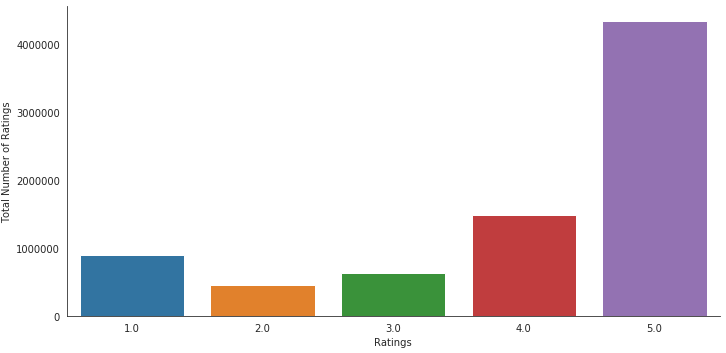

In [8]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.factorplot("Ratings", data=df_master, aspect=2.0, kind='count')
    g.set_ylabels("Total Number of Ratings")

In [9]:
#Common function to display cross tab between Ratings and ProductID, Ratings and UserID
def cross_tab(df,f1,f2):
    product = list(df[f1].unique())
    user = list(df[f2].unique())
    dataframes = []
    for e in user:
        dfe = df[df[f2] == e]
        dfeproduct = dfe.groupby(f1).count()[f2]
        dataframes.append(dfeproduct)
    xx = pd.concat(dataframes,axis = 1)
    xx.columns = user
    xx = xx.fillna(0)
    return xx

In [10]:
#Productwise ratings count
cross_tab(df_master,'ProductID', 'Ratings')

,5.0,1.0,3.0,2.0,4.0
0132793040,1.0,0.0,0.0,0.0,0.0
0321732944,1.0,0.0,0.0,0.0,0.0
0439886341,0.0,2.0,1.0,0.0,0.0
0511189877,5.0,0.0,0.0,1.0,0.0
0528881469,7.0,9.0,1.0,5.0,5.0
...,...,...,...,...,...
BT008G3W52,1.0,0.0,0.0,0.0,0.0
BT008SXQ4C,0.0,1.0,0.0,0.0,0.0
BT008T2BGK,1.0,0.0,0.0,0.0,0.0
BT008UKTMW,7.0,1.0,2.0,1.0,4.0


- Overall 476,002 unique products which are rated by users

In [11]:
#Userwise ratings count
cross_tab(df_master,'UserID', 'Ratings')

,5.0,1.0,3.0,2.0,4.0
A00000262KYZUE4J55XGL,1.0,0.0,0.0,0.0,0.0
A000063614T1OE0BUSKUT,2.0,0.0,0.0,0.0,0.0
A00009182QVLSWIGHLS1B,1.0,0.0,0.0,0.0,0.0
A00009661LC9LQPGKJ24G,1.0,0.0,0.0,0.0,0.0
A00010809P09NUU6ZP6H,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
AZZZOVIBXHGDR,1.0,1.0,0.0,0.0,1.0
AZZZRS1YZ8HVP,0.0,0.0,0.0,0.0,2.0
AZZZSIK7NFFVP,1.0,0.0,0.0,0.0,0.0
AZZZWXXUPZ1F3,1.0,0.0,0.0,0.0,0.0


- Overall 4,201,696 unique users who have rated products.

In [12]:
# Number of unique user id  in the data
print('Number of Unique Users = ', df_master['UserID'].nunique())
# Number of unique product id  in the data
print('Number of Unique Product = ', df_master['ProductID'].nunique())

Number of Unique Users =  4201696
Number of Unique Product =  476002


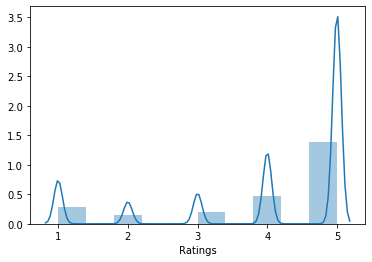

In [13]:
#Let us use seaborn distplot to analyze the distribution of individual ratings and see the skewness in attributes
sns.distplot(df_master["Ratings"], bins=10)

- Individual ratings are normally distributed

## Step 2 - Take a subset of the dataset to make it less sparse/ denser. (For example, keep the users only who has given 50 or more number of ratings ) - (2.5 Marks)

In [14]:
#Check the top 10 users who have given most ratings
popular_users = pd.DataFrame(df_master.groupby('UserID')['Ratings'].count())
most_popular_users = popular_users.sort_values('Ratings', ascending = False)
most_popular_users.head(10)

,Ratings
UserID,
A5JLAU2ARJ0BO,520
ADLVFFE4VBT8,501
A3OXHLG6DIBRW8,498
A6FIAB28IS79,431
A680RUE1FDO8B,406
A1ODOGXEYECQQ8,380
A36K2N527TXXJN,314
A2AY4YUOX2N1BQ,311
AWPODHOB4GFWL,308


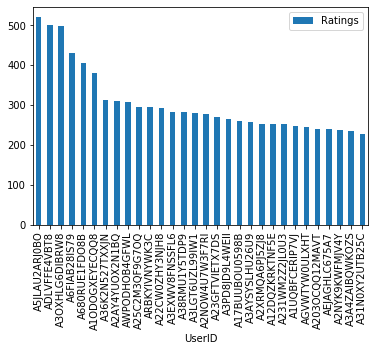

In [15]:
most_popular_users.head(30).plot(kind = "bar")

In [16]:
#Check the top 10 most popular products
popular_products = pd.DataFrame(df_master.groupby('ProductID')['Ratings'].count())
most_popular_products = popular_products.sort_values('Ratings', ascending=False)
most_popular_products.head(10)

,Ratings
ProductID,
B0074BW614,18244
B00DR0PDNE,16454
B007WTAJTO,14172
B0019EHU8G,12285
B006GWO5WK,12226
B003ELYQGG,11617
B003ES5ZUU,10276
B007R5YDYA,9907
B00622AG6S,9823


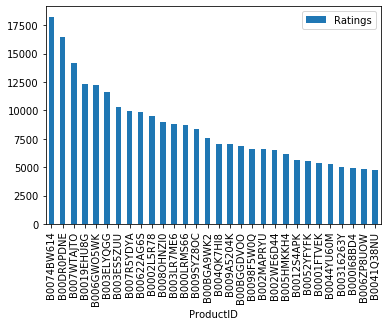

In [17]:
most_popular_products.head(30).plot(kind = "bar")

In [18]:
counts = df_master.UserID.value_counts()
df_master_truncated = df_master[df_master.UserID.isin(counts[counts >= 50].index)]
print('Number of users who have rated 50 or more items =', len(df_master_truncated))
print('Number of unique users in the final data = ', df_master_truncated['UserID'].nunique())
print('Number of unique products in the final data = ', df_master_truncated['ProductID'].nunique())

Number of users who have rated 50 or more items = 125871
Number of unique users in the final data =  1540
Number of unique products in the final data =  48190


In [19]:
df_master_truncated.shape

(125871, 3)

### Ratings Analysis in Truncated Dataset

In [20]:
#constructing the pivot table
final_ratings_matrix = df_master_truncated.pivot(index='UserID', columns='ProductID', values='Ratings').fillna(0)
final_ratings_matrix.head()

ProductID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
UserID,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- Above table shows that it is a sparse matrix. 
- Many cells are filled with 0 values.

In [21]:
final_ratings_matrix.shape

(1540, 48190)

- We can see that there are 48,190 products and 1,540 users.

In [22]:
#Calucating the density of the rating marix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('Given Number of Ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('Possible Number of Ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('Density: {:4.2f}%'.format(density))

Given Number of Ratings =  125871
Possible Number of Ratings =  74212600
Density: 0.17%


- The density value of the matrix also shows that it is a sparse matrix.

## Step 3 - Split the data randomly into train and test dataset. (For example, split it in 70/30 ratio) - (2.5 Marks)

In [23]:
#Split the data randomnly into train and test datasets into 70:30 ratio
train_data, test_data = train_test_split(df_master_truncated, test_size = 0.3, random_state = 50)
train_data.head()

,UserID,ProductID,Ratings
3916061,A3LQUEB84IR3VO,B0046TJG1U,5.0
5840223,A8FKL1DHTHC12,B007PE3FC4,5.0
7309658,ANSVB7OYSXZSL,B00CRY250U,2.0
6010221,A3T7V207KRDE2O,B0081FLFQE,5.0
4600799,A3ER6ARJ23CIN8,B004ZH62PQ,5.0


In [24]:
print('Shape of Training Data: ', train_data.shape)
print('Shape of Testing Data: ', test_data.shape)

Shape of Training Data:  (88109, 3)
Shape of Testing Data:  (37762, 3)


## Step 4 - Build Popularity Recommender Model. - (20 Marks)

In [25]:
#Count of UserID for each unique ProductID and Mean of respective ProductID ratintgs as recommendation score 
train_data_grouped = train_data.groupby('ProductID').agg({'UserID': 'count', 'Ratings': 'mean'}).reset_index()
train_data_grouped.rename(columns = {'UserID': 'RatingsCount'}, inplace = True)
train_data_grouped.rename(columns = {'Ratings': 'RatingsAvg'}, inplace = True)
train_data_grouped.head(10)

,ProductID,RatingsCount,RatingsAvg
0,0594481813,1,3.000000
1,0970407998,1,4.000000
2,0972683275,3,4.666667
3,1400501466,5,3.000000
4,1400501520,1,5.000000
5,1400501776,2,4.500000
6,1400532620,2,3.000000
7,1400532655,4,3.250000
8,140053271X,1,4.000000
9,1400599997,4,4.750000


In [26]:
#Taking a subset of rating data where more than 100 ratings are given to a product
train_data_grouped = train_data_grouped.iloc[np.where(train_data_grouped['RatingsCount'] > 100)]

#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['RatingsAvg', 'RatingsCount'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['Rank'] = train_data_sort['RatingsAvg'].rank(ascending = 0, method = 'first') 

#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations

,ProductID,RatingsCount,RatingsAvg,Rank
19539,B003ES5ZUU,132,4.893939,1.0
8631,B000N99BBC,120,4.783333,2.0
30200,B007WTAJTO,119,4.697479,3.0
30483,B00829TIEK,104,4.423077,4.0
30792,B0088CJT4U,141,4.177305,5.0


In [27]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['User'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations

In [28]:
find_recom = [4, 6, 8]   #This list is a user choice.
for i in find_recom:
    print("The list of Product Recommendations for the User: \n", i)
    print(recommend(i))    
    print("\n")

The list of Product Recommendations for the User: 
 4
       User   ProductID  RatingsCount  RatingsAvg  Rank
19539     4  B003ES5ZUU           132    4.893939   1.0
8631      4  B000N99BBC           120    4.783333   2.0
30200     4  B007WTAJTO           119    4.697479   3.0
30483     4  B00829TIEK           104    4.423077   4.0
30792     4  B0088CJT4U           141    4.177305   5.0


The list of Product Recommendations for the User: 
 6
       User   ProductID  RatingsCount  RatingsAvg  Rank
19539     6  B003ES5ZUU           132    4.893939   1.0
8631      6  B000N99BBC           120    4.783333   2.0
30200     6  B007WTAJTO           119    4.697479   3.0
30483     6  B00829TIEK           104    4.423077   4.0
30792     6  B0088CJT4U           141    4.177305   5.0


The list of Product Recommendations for the User: 
 8
       User   ProductID  RatingsCount  RatingsAvg  Rank
19539     8  B003ES5ZUU           132    4.893939   1.0
8631      8  B000N99BBC           120    4.783333 

- The above model is the Popularity Based Recommender Model; hence all the users are given the same recommendations. Here, the model predicts the products based on popularity, not on user profiling or personalization.

## Step 5 - Build Collaborative Filtering Model. - (20 Marks)

In [29]:
df_master_truncated.head()

,UserID,ProductID,Ratings
94,A3BY5KCNQZXV5U,0594451647,5.0
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
492,A3CLWR1UUZT6TG,0972683275,5.0


### User Based Collaborative Filtering Model

In [30]:
# Matrix with row per 'user' and column per 'item' 
pivot_df = df_master_truncated.pivot(index = 'UserID', columns ='ProductID', values = 'Ratings').fillna(0)
pivot_df.head()

ProductID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
UserID,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
#Shape of pivot
print('Shape of the Pivot Table: ', pivot_df.shape)

Shape of the Pivot Table:  (1540, 48190)


In [32]:
#Define user index from 0 to 10
pivot_df['UserIndex'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

ProductID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8,UserIndex
UserID,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [33]:
pivot_df.set_index(['UserIndex'], inplace = True)
#Actual ratings given by users
pivot_df.head(10)

ProductID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
UserIndex,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- Given, it is a Sparse Matrix, hence there is a need of SVD method

### Singular Value Decomposition

In [34]:
U, sigma, Vt = svds(pivot_df, k = 10)

In [35]:
print('Left Singular Matrix: \n', U)

Left Singular Matrix: 
 [[ 0.00899214  0.00598943 -0.01133778 ... -0.02098223 -0.03450332
  -0.02112691]
 [ 0.0078874   0.01984352 -0.00397075 ... -0.01076097  0.02009915
  -0.03863719]
 [ 0.00060497 -0.00421198 -0.00381018 ...  0.02924332  0.03319807
  -0.03354122]
 ...
 [-0.0069631   0.0863053   0.02353607 ... -0.01332978 -0.1613707
  -0.05949368]
 [-0.00238725  0.0032176  -0.00374118 ... -0.00677598  0.00445708
  -0.01348483]
 [-0.00097386  0.00410379  0.002161   ... -0.01215862 -0.00249329
  -0.00561029]]


In [36]:
print('Sigma: \n', sigma)

Sigma: 
 [ 87.43474122  88.68897677  91.15027972  92.15989229  95.03789667
  98.21626326 100.38232831 107.7090351  119.69501814 182.29276718]


In [37]:
#Construct diagonal array in SVD
sigma = np.diag(sigma)
print('Diagonal matrix: \n', sigma)

Diagonal matrix: 
 [[ 87.43474122   0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.          88.68897677   0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.          91.15027972   0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.          92.15989229   0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.          95.03789667
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
   98.21626326   0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.         100.38232831   0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.      

In [38]:
print('Right Singular Matrix: \n', Vt)

Right Singular Matrix: 
 [[-2.31966546e-04 -4.68044406e-04 -1.43854010e-04 ...  2.30584720e-02
   8.19034231e-03  1.83182807e-03]
 [-1.20917225e-04 -5.52580088e-04  3.34185097e-04 ... -2.44735821e-02
  -4.79762018e-04 -1.00226998e-03]
 [ 2.66495818e-04  1.86012492e-04 -4.76652015e-04 ...  9.93151909e-03
   2.54217806e-03 -4.78476864e-04]
 ...
 [-8.81590303e-04 -1.31370545e-03 -4.21874643e-04 ...  1.37986535e-02
   4.52761832e-03 -1.09691626e-03]
 [-4.58579287e-05 -1.88881713e-04 -9.00497985e-05 ... -3.32629345e-02
  -1.31262740e-02 -2.24988359e-03]
 [-2.02226218e-04 -2.59177123e-04 -6.62049181e-04 ... -1.02695130e-02
  -3.76431121e-03 -8.69030592e-04]]


In [39]:
#Predicted ratings
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
#Convert predicted ratings to dataframe
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

ProductID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.002661,0.003576,0.004050,0.006906,0.003967,0.003073,0.005782,0.000568,0.014386,0.002708,...,6.108890e-04,0.044224,0.002919,0.060347,-0.002137,0.006751,0.001525,0.130951,0.059243,0.015014
1,0.002262,0.002505,0.005136,0.016517,0.007120,0.001438,0.013258,0.000335,-0.003781,0.001190,...,2.024793e-04,0.029213,0.000010,0.000244,-0.003111,-0.000621,0.004409,-0.039241,-0.006889,0.003696
2,-0.001600,-0.002502,0.002186,0.016742,0.006716,-0.002113,0.005805,0.003497,-0.005009,-0.001588,...,-3.240446e-04,0.009180,-0.002459,-0.016922,0.019936,-0.002483,-0.000155,-0.002889,-0.011522,-0.004525
3,0.002732,0.003867,0.001799,0.009395,0.004075,0.002778,0.003507,0.000095,0.007983,0.002381,...,6.031462e-04,-0.003369,0.003433,-0.003428,-0.000750,0.000119,0.002612,-0.015107,-0.006740,0.003276
4,0.000704,0.000085,0.002051,0.009664,0.004438,0.000335,0.005992,0.001056,-0.000369,0.000373,...,3.745108e-08,-0.001140,-0.000323,-0.025215,0.004700,-0.002170,0.001263,-0.048555,-0.016301,-0.003377


In [40]:
# Recommend the items with the highest predicted ratings
def recommend_items(user_id, pivot_df, preds_df, num_recommendations):
    # index starts at 0  
    user_idx = user_id - 1 
    #Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending = False)
    #Sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending = False)
    #Sorted_user_predictions
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis = 1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['UserRatings', 'UserPredictions']
    temp = temp.loc[temp.UserRatings == 0]
    temp = temp.sort_values('UserPredictions', ascending = False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [41]:
userID = 4
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 4):

                   UserRatings  UserPredictions
Recommended Items                              
B007WTAJTO                 0.0         0.824345
B003ES5ZUU                 0.0         0.664491
B002V88HFE                 0.0         0.430415
B001TH7GUU                 0.0         0.387479
B005FYNSPK                 0.0         0.360464


In [42]:
userID = 6
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 6):

                   UserRatings  UserPredictions
Recommended Items                              
B00829TIEK                 0.0         1.354348
B008DWCRQW                 0.0         1.194768
B004CLYEDC                 0.0         1.021913
B002R5AM7C                 0.0         0.934417
B00829THK0                 0.0         0.926751


In [43]:
userID = 8
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 8):

                   UserRatings  UserPredictions
Recommended Items                              
B003ES5ZUU                 0.0         1.919363
B002V88HFE                 0.0         1.430753
B002WE6D44                 0.0         1.258002
B001TH7GUU                 0.0         1.249597
B005HMKKH4                 0.0         0.976093


- The above model is the a Collaborative Recommender Model, hence, all the three users are given different recommendations based on users past behaviour.

## Step 6 - Evaluate both the models. (Once the model is trained on the training data, it can be used to compute the error (RMSE) on predictions made on the test data.) - (7.5 Marks)

In [44]:
#Actual ratings given by the users
final_ratings_matrix.head()

ProductID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
UserID,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
#Predicted ratings by SVD
preds_df.head()

ProductID,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.002661,0.003576,0.004050,0.006906,0.003967,0.003073,0.005782,0.000568,0.014386,0.002708,...,6.108890e-04,0.044224,0.002919,0.060347,-0.002137,0.006751,0.001525,0.130951,0.059243,0.015014
1,0.002262,0.002505,0.005136,0.016517,0.007120,0.001438,0.013258,0.000335,-0.003781,0.001190,...,2.024793e-04,0.029213,0.000010,0.000244,-0.003111,-0.000621,0.004409,-0.039241,-0.006889,0.003696
2,-0.001600,-0.002502,0.002186,0.016742,0.006716,-0.002113,0.005805,0.003497,-0.005009,-0.001588,...,-3.240446e-04,0.009180,-0.002459,-0.016922,0.019936,-0.002483,-0.000155,-0.002889,-0.011522,-0.004525
3,0.002732,0.003867,0.001799,0.009395,0.004075,0.002778,0.003507,0.000095,0.007983,0.002381,...,6.031462e-04,-0.003369,0.003433,-0.003428,-0.000750,0.000119,0.002612,-0.015107,-0.006740,0.003276
4,0.000704,0.000085,0.002051,0.009664,0.004438,0.000335,0.005992,0.001056,-0.000369,0.000373,...,3.745108e-08,-0.001140,-0.000323,-0.025215,0.004700,-0.002170,0.001263,-0.048555,-0.016301,-0.003377


In [46]:
#Average predicted rating for each item
preds_df.mean().head()

ProductID
0594451647    0.001542
0594481813    0.002341
0970407998    0.002597
0972683275    0.011807
1400501466    0.004848
dtype: float64

In [47]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis = 1)
rmse_df.columns = ['AvgActualRatings', 'AvgPredictedRatings']
print(rmse_df.shape)
rmse_df['ItemIndex'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(48190, 2)


,AvgActualRatings,AvgPredictedRatings,ItemIndex
ProductID,,,
0594451647,0.003247,0.001542,0
0594481813,0.001948,0.002341,1
0970407998,0.003247,0.002597,2
0972683275,0.012338,0.011807,3
1400501466,0.012987,0.004848,4


In [48]:
RMSE = round((((rmse_df.AvgActualRatings - rmse_df.AvgPredictedRatings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.0033 



### RMSE SVD Model = 0.0033

## Step 7 - Get top - K ( K = 5) recommendations. Since our goal is to recommend new products for each user based on his/her habits, we will recommend 5 new products. - (7.5 Marks)

In [49]:
#Enter 'userID' and 'num_recommendations' for the user #
userID = 9
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 9):

                   UserRatings  UserPredictions
Recommended Items                              
B009NHWVIA                 0.0         0.990750
B004CLYEFK                 0.0         0.973048
B007WTAJTO                 0.0         0.963049
B0088CJT4U                 0.0         0.921804
B0097CXWUW                 0.0         0.798987


## Step 8 - Summarise your insights. - (7.5 marks)

- The popularity-based recommender system is non-personalized and based on frequency counts, which may be not suitable to the user. We can see the difference above for user id 4, 6 & 8, The Popularity based model has recommended the same set of 5 products to all but the Collaborative Filtering based model has recommended an entirely different list based on the user's past purchase history.
- Model-based Collaborative Filtering is a personalized recommender system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information.